In [1]:
#We import the necessary libraries.
import pandas as pd
import re
from datetime import date
from tqdm import tqdm
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Combining Original CSV Files

In [2]:
#We create a list of all existing newspapers in the dataset
newspapers = ["gooieneemlander", "haarlemsdagblad", "ijmuidercourant", "leidschdagblad", "noordhollandsdagblad"]

#We create an empty list.
df = []

#We create an object equal to zero.
length = 0

#We loop over all the newspapers.
for n in tqdm(newspapers):
    #We store each RAW newspaper file as a seperate object, by their respective names.
    globals()[n] = pd.read_csv(f"{n}.nl.csv")
    #We add to it a column with the name of the newspaper.
    globals()[n]["Newspaper"] = n.title()
    
    #We sum the length of the current data-object with the zero object.
    length += len(globals()[n])

    #We add the newspaper per-hour objects to a list.
    df.append(globals()[n])

#We stack the list of data objects together.
df = pd.concat(df, ignore_index = True)

#We check if the length of the seperate objects combined equals the length of the definitive dataframe.
print(f"Length of df equals sum of seperate newspaper dataframes = {len(df) == length}.")

100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Length of df equals sum of seperate newspaper dataframes = True.


In [3]:
#We inspect the data.
df.head()

,Hostnaam,Bron/medium,Bestemmingspagina,Sessies,timestamp,Newspaper
0,m.gooieneemlander.nl,google / organic,/cnt/DMF20210612_49952447,80,2021-06-12 19:11:00,Gooieneemlander
1,m.gooieneemlander.nl,google / organic,/cnt/DMF20210612_49952447,76,2021-06-12 19:10:00,Gooieneemlander
2,m.gooieneemlander.nl,google / organic,/cnt/DMF20210612_49952447,66,2021-06-12 19:15:00,Gooieneemlander
3,m.gooieneemlander.nl,google / organic,/cnt/DMF20210612_49952447,64,2021-06-12 19:09:00,Gooieneemlander
4,m.gooieneemlander.nl,google / organic,/cnt/DMF20210612_49952447,64,2021-06-12 19:12:00,Gooieneemlander


## Cleaning Combined CSV File

In [4]:
#We use a regular expression to extract the main traffic source (everything after the '/' symbol).
df["Traffic source"] = df["Bron/medium"].apply(lambda x: re.search("/ (.*)", x).group(1))

In [5]:
#We use a regular expression to extract the specific source (everything before the '/' symbol).
df["Explicit source"] = df["Bron/medium"].apply(lambda x: re.search("(.*) / ", x).group(1))

In [6]:
#We use a regular expression to extract the landing page.
df["Landing page"] = df["Bestemmingspagina"].apply(lambda x: re.search(r"\/cnt\/dmf(\d+)_\d+", x.lower()).group(0))

In [7]:
#We quickly sort our dataset on the length of the landing page, to see if the streamlining went correctly 
#Thus if we do not have very short or very long landing page ids.
df.sort_values(by="Landing page", key=lambda x: x.str.len())

,Hostnaam,Bron/medium,Bestemmingspagina,Sessies,timestamp,Newspaper,Traffic source,Explicit source,Landing page
6519549,m.noordhollandsdagblad.nl,google / organic,/cnt/dmf20200812_110,1,2021-04-20 00:12:00,Noordhollandsdagblad,organic,google,/cnt/dmf20200812_110
5414147,m.noordhollandsdagblad.nl,google / organic,/cnt/dmf20191229_491,1,2021-06-23 17:16:00,Noordhollandsdagblad,organic,google,/cnt/dmf20191229_491
7472731,m.noordhollandsdagblad.nl,google / organic,/cnt/dmf20191229_491,1,2021-05-23 07:03:00,Noordhollandsdagblad,organic,google,/cnt/dmf20191229_491
6513925,www.noordhollandsdagblad.nl,google / organic,/cnt/dmf20200812_110,1,2021-04-19 21:26:00,Noordhollandsdagblad,organic,google,/cnt/dmf20200812_110
4127930,m.noordhollandsdagblad.nl,nhd / push,/cnt/dmf20200812_110,1,2021-06-08 19:36:00,Noordhollandsdagblad,push,nhd,/cnt/dmf20200812_110
...,...,...,...,...,...,...,...,...,...
3190314,www.leidschdagblad.nl,google / organic,/cnt/dmf20210428_53029421,1,2021-04-30 13:20:00,Leidschdagblad,organic,google,/cnt/dmf20210428_53029421
3190312,www.leidschdagblad.nl,facebook / social,/cnt/DMF20210430_68672222,1,2021-04-30 13:20:00,Leidschdagblad,social,facebook,/cnt/dmf20210430_68672222
3190311,m.leidschdagblad.nl,upday / referral,/cnt/dmf20210424_93095284,1,2021-04-30 13:20:00,Leidschdagblad,referral,upday,/cnt/dmf20210424_93095284
3190326,m.leidschdagblad.nl,m.facebook.com / referral,/cnt/dmf20210430_58054478,1,2021-04-30 13:21:00,Leidschdagblad,referral,m.facebook.com,/cnt/dmf20210430_58054478


In [8]:
#We remove the minutes and seconds as we want to aggregate per hour.
df["Timestamp date"] = df["timestamp"].apply(lambda x: x[:-5] + "00:00")

## Referrals Origins

In [9]:
Counter(df[df["Traffic source"] == "referral"]["Explicit source"]).most_common(30)

[('m.facebook.com', 1129729),
 ('upday', 108453),
 ('l.facebook.com', 85848),
 ('t.co', 66169),
 ('accounts.tnet.nl', 62971),
 ('www.haarlemsdagblad.nl', 20640),
 ('drimble.nl', 19834),
 ('www.noordhollandsdagblad.nl', 12050),
 ('www.gooieneemlander.nl', 10248),
 ('android-app:', 9703),
 ('www.leidschdagblad.nl', 8372),
 ('www.ijmuidercourant.nl', 7724),
 ('lm.facebook.com', 5367),
 ('www.linkedin.com', 4864),
 ('www.groot-waterland.nl', 4620),
 ('tnet.nl', 4441),
 ('www.ad.nl', 4286),
 ('noordhollandsdagblad.nl', 3234),
 ('m.noordhollandsdagblad.nl', 2986),
 ('www.geenstijl.nl', 2725),
 ('www.autoblog.nl', 2087),
 ('www.rtlnieuws.nl', 1968),
 ('horizon.obi4wan.com', 1939),
 ('www.oozo.nl', 1813),
 ('www.facebook.com', 1437),
 ('www.startpage.com', 1429),
 ('m.haarlemsdagblad.nl', 1281),
 ('mediahuis.nl', 1246),
 ('www.heiloo-online.nl', 1168),
 ('transition.meltwater.com', 1143)]

In [10]:
#We drop the old columns.
df = df.drop(columns = ["Hostnaam", "Bron/medium", "Bestemmingspagina", "timestamp"])

In [11]:
#We rename the 'Sessies' column.
df.rename(columns = {"Sessies": "Views"}, inplace = True)

In [12]:
#We inspect the data.
df.head()

,Views,Newspaper,Traffic source,Explicit source,Landing page,Timestamp date
0,80,Gooieneemlander,organic,google,/cnt/dmf20210612_49952447,2021-06-12 19:00:00
1,76,Gooieneemlander,organic,google,/cnt/dmf20210612_49952447,2021-06-12 19:00:00
2,66,Gooieneemlander,organic,google,/cnt/dmf20210612_49952447,2021-06-12 19:00:00
3,64,Gooieneemlander,organic,google,/cnt/dmf20210612_49952447,2021-06-12 19:00:00
4,64,Gooieneemlander,organic,google,/cnt/dmf20210612_49952447,2021-06-12 19:00:00


In [13]:
#We create an empty list.
traffic_source = []

#We loop over the traffic sources and categorize them accordingly.
for item in tqdm(df["Traffic source"].values):
    if item == "newsletter" or item == "email":
        traffic_source.append("newsletter")
    elif item == "organic":
        traffic_source.append("organic")
    elif item == "referral":
        traffic_source.append("referral")
    elif item == "social" or item == "twitter" or item == "facebook":
        traffic_source.append("social")
    elif item == "push":
        traffic_source.append("push")
    else:
        traffic_source.append("other")

100%|██████████| 9130799/9130799 [00:04<00:00, 2268537.97it/s]


In [14]:
#We add the list as a column
df["Traffic source"] = traffic_source

In [15]:
#We inspect the presence of the categories
Counter(traffic_source).most_common()

[('organic', 2470151),
 ('social', 1895509),
 ('newsletter', 1658249),
 ('referral', 1627818),
 ('push', 748291),
 ('other', 730781)]

## Main Traffic Source Dataset

In [16]:
#We group by hour by publication by traffic source, and sum the data, so that we get the amount of views per hour per publication per traffic source.
df = df.groupby(["Newspaper", "Landing page", "Traffic source", "Timestamp date"])["Views"].sum().reset_index()\
       .sort_values(["Newspaper", "Landing page", "Timestamp date"])

In [17]:
#We check if there exist duplicate rows.
print(df.duplicated().value_counts())

False    2419448
dtype: int64


In [18]:
#We inspect the data.
df.head()

,Newspaper,Landing page,Traffic source,Timestamp date,Views
0,Gooieneemlander,/cnt/dmf20180830_13090784,other,2021-05-06 12:00:00,1
1,Gooieneemlander,/cnt/dmf20180830_15395191,organic,2021-06-12 22:00:00,1
2,Gooieneemlander,/cnt/dmf20180830_21070680,organic,2021-04-13 17:00:00,1
3,Gooieneemlander,/cnt/dmf20180830_21070680,referral,2021-06-01 13:00:00,1
4,Gooieneemlander,/cnt/dmf20180830_31246891,organic,2021-06-16 18:00:00,1


## Implementing Publication Dates

In [19]:
#We load in our earlier created publications dates (from the combined meta file in script I).
df2 = pd.read_csv("Publication dates.csv")

In [20]:
#We inspect the data.
df2.head()

,Landing page,Newspaper,Publication date
0,/cnt/dmf20210612_49952447,Gooieneemlander,2021-06-12 18:00:00
1,/cnt/dmf20210611_74078660,Gooieneemlander,2021-06-11 17:00:00
2,/cnt/dmf20210609_6603454,Gooieneemlander,2021-06-09 16:00:00
3,/cnt/dmf20210609_60025534,Gooieneemlander,2021-06-09 17:00:00
4,/cnt/dmf20210608_17288936,Gooieneemlander,2021-06-08 15:00:00


In [21]:
#We merge the files on publication.
df3 = df.merge(df2, how="left", on=["Newspaper", "Landing page"])

In [22]:
#We inspect it.
df3.head()

,Newspaper,Landing page,Traffic source,Timestamp date,Views,Publication date
0,Gooieneemlander,/cnt/dmf20180830_13090784,other,2021-05-06 12:00:00,1,2018-08-29 16:00:00
1,Gooieneemlander,/cnt/dmf20180830_15395191,organic,2021-06-12 22:00:00,1,2018-08-29 20:00:00
2,Gooieneemlander,/cnt/dmf20180830_21070680,organic,2021-04-13 17:00:00,1,2018-08-30 14:00:00
3,Gooieneemlander,/cnt/dmf20180830_21070680,referral,2021-06-01 13:00:00,1,2018-08-30 14:00:00
4,Gooieneemlander,/cnt/dmf20180830_31246891,organic,2021-06-16 18:00:00,1,2018-08-30 15:00:00


In [23]:
#We check the datatypes.
df3.dtypes

Newspaper           object
Landing page        object
Traffic source      object
Timestamp date      object
Views                int64
Publication date    object
dtype: object

In [24]:
#We transform it to datetime objects.
df3["Publication date"] = pd.to_datetime(df3["Publication date"].values, format="%Y-%m-%d %H:%M:%S")
df3["Timestamp date"] = pd.to_datetime(df3["Timestamp date"].values, format="%Y-%m-%d %H:%M:%S")

In [25]:
#We check the datatypes.
df3.dtypes

Newspaper                   object
Landing page                object
Traffic source              object
Timestamp date      datetime64[ns]
Views                        int64
Publication date    datetime64[ns]
dtype: object

In [26]:
#We verify what the start of the tracking period is.
df3.groupby(["Newspaper"])["Timestamp date"].min()

Newspaper
Gooieneemlander        2021-04-12
Haarlemsdagblad        2021-04-12
Ijmuidercourant        2021-04-12
Leidschdagblad         2021-04-12
Noordhollandsdagblad   2021-04-12
Name: Timestamp date, dtype: datetime64[ns]

In [27]:
#We subset the data accordingly to make sure that we have data on the full trajectory of each article. 
#We thus exclude articles that are published before the data collection started.
#To be sure we also exclude timestamps that occured before the publication date.
df3 = df3[(df3["Publication date"] >= "2021-04-12 00:00:00") & (df3["Timestamp date"] >= df3["Publication date"])]

In [28]:
#We inspect the data.
df3.head()

,Newspaper,Landing page,Traffic source,Timestamp date,Views,Publication date
37536,Gooieneemlander,/cnt/dmf20190705_81476516,referral,2021-05-27 16:00:00,1,2021-05-26 19:00:00
37537,Gooieneemlander,/cnt/dmf20190705_81476516,referral,2021-05-27 22:00:00,1,2021-05-26 19:00:00
37538,Gooieneemlander,/cnt/dmf20190705_81476516,other,2021-05-28 08:00:00,1,2021-05-26 19:00:00
47717,Gooieneemlander,/cnt/dmf20200501_53506347,other,2021-07-05 18:00:00,1,2021-07-05 18:00:00
47718,Gooieneemlander,/cnt/dmf20200501_53506347,referral,2021-07-05 18:00:00,3,2021-07-05 18:00:00


In [29]:
#We check if the first record is equal to the publication date.
Counter(df3.groupby(["Newspaper", "Landing page", "Traffic source"])\
        .apply(lambda x: (x["Publication date"].iloc[0] == x["Timestamp date"].iloc[0])))

Counter({False: 75019, True: 52947})

In [30]:
#We create a function to add a row.
def add_row_traffic(x):
    #Namely we check for publications where the first timestamp is not equal to the publication date.
    if x["Timestamp date"].min() != x["Publication date"].iloc[0]:
        #If so we add a new custom row to the top of the publication.
        #This row will have the same information as the other rows, having zero views and having a timestamp equal to the publication date.
        #This is done so that the gap between the publication date and the first timestamp can be filled up later on.
        return pd.concat([pd.DataFrame({"Landing page": x["Landing page"].iloc[0],
                                        "Traffic source": x["Traffic source"].iloc[0],
                                        "Views": 0,
                                        "Newspaper": x["Newspaper"].iloc[0],
                                        "Publication date": x["Publication date"].iloc[0],
                                        "Timestamp date": x["Publication date"].iloc[0]
                                       }, index=[0]), x]).reset_index(drop=True)
    return x

In [31]:
#We apply the function.
df3 = df3.groupby(["Newspaper", "Landing page", "Traffic source"]).apply(add_row_traffic).reset_index(drop=True)

In [32]:
#We check if it worked.
Counter(df3.groupby(["Newspaper", "Landing page", "Traffic source"])\
        .apply(lambda x: (x["Publication date"].iloc[0] == x["Timestamp date"].iloc[0])))

Counter({True: 127966})

In [33]:
#We inspect the data.
df3.head()

,Landing page,Traffic source,Views,Newspaper,Publication date,Timestamp date
0,/cnt/dmf20190705_81476516,other,0,Gooieneemlander,2021-05-26 19:00:00,2021-05-26 19:00:00
1,/cnt/dmf20190705_81476516,other,1,Gooieneemlander,2021-05-26 19:00:00,2021-05-28 08:00:00
2,/cnt/dmf20190705_81476516,referral,0,Gooieneemlander,2021-05-26 19:00:00,2021-05-26 19:00:00
3,/cnt/dmf20190705_81476516,referral,1,Gooieneemlander,2021-05-26 19:00:00,2021-05-27 16:00:00
4,/cnt/dmf20190705_81476516,referral,1,Gooieneemlander,2021-05-26 19:00:00,2021-05-27 22:00:00


In [34]:
#We pivot our data so that each traffic source gets its own views column.
df3_p = df3.pivot_table(columns="Traffic source", index = ["Newspaper", "Landing page", "Timestamp date"],
                        values="Views", fill_value=0).reset_index().rename_axis(None, axis=1)

In [35]:
#We fill up the spaces between the timestamps with rows of 1 hour.
#.sum() is used so that views get a value of zero (the whole reason that the timestamp was missing was because there were zero views).
df3_p = df3_p.groupby(["Newspaper", "Landing page"]).apply(lambda x: x.set_index("Timestamp date").resample("1H").sum()).reset_index()

In [36]:
#We check if the difference is now indeed 1 across each row per publication.
Counter(df3_p.groupby(["Newspaper", "Landing page"])["Timestamp date"].diff())

Counter({NaT: 46550, Timedelta('0 days 01:00:00'): 17737802})

In [37]:
#We inspect the data.
df3_p.head()

,Newspaper,Landing page,Timestamp date,newsletter,organic,other,push,referral,social
0,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 19:00:00,0,0,0,0,0,0
1,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 20:00:00,0,0,0,0,0,0
2,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 21:00:00,0,0,0,0,0,0
3,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 22:00:00,0,0,0,0,0,0
4,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 23:00:00,0,0,0,0,0,0


## Adding Traffic Features

In [38]:
#We order the dataframe on date within each publication (this is how the file was already structured, but just to be sure).
df3_p = df3_p.groupby(["Newspaper", "Landing page"]).apply(lambda x: x.sort_values("Timestamp date")).reset_index(drop=True)

In [39]:
#We add the value one as a column, the difference between rows is namely 1 hour across publications.
df3_p["Hour"] = 1
#We take the sum of this column cumulatively within each publication, thus creating the hours passed.
df3_p["Hours passed"] = df3_p.groupby(["Newspaper", "Landing page"])["Hour"].cumsum()
#We drop the original column.
df3_p.drop(columns = ["Hour"], inplace = True)

In [40]:
#We fill up spaces and special symbols in our column names (as otherwise they will not work in formula et cetera).
df3_p.columns = [c.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "").replace(".", "") for c in df3_p.columns]

In [41]:
#We loop over the source columns and group by publication to get the total amount of views per publication within a traffic source.
for source in tqdm(["newsletter", "organic", "other", "push", "referral", "social"]):
    df3_p[f"Total_{source}"] = df3_p.groupby(["Newspaper", "Landing_page"])[f"{source}"].transform("sum")

100%|██████████| 6/6 [00:19<00:00,  3.23s/it]


In [42]:
#We also create an total views per hours column (by simply adding up the views within each traffic source).
df3_p["Views"] = df3_p["newsletter"] + df3_p["organic"] + df3_p["other"] + df3_p["push"] + df3_p["referral"] + df3_p["social"]
#And an absolute total by grouping per publication.
df3_p["Total_views"] = df3_p.groupby(["Newspaper", "Landing_page"])["Views"].transform("sum")

In [43]:
#We inspect the data.
df3_p.head()

,Newspaper,Landing_page,Timestamp_date,newsletter,organic,other,push,referral,social,Hours_passed,Total_newsletter,Total_organic,Total_other,Total_push,Total_referral,Total_social,Views,Total_views
0,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 19:00:00,0,0,0,0,0,0,1,0,0,1,0,2,0,0,3
1,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 20:00:00,0,0,0,0,0,0,2,0,0,1,0,2,0,0,3
2,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 21:00:00,0,0,0,0,0,0,3,0,0,1,0,2,0,0,3
3,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 22:00:00,0,0,0,0,0,0,4,0,0,1,0,2,0,0,3
4,Gooieneemlander,/cnt/dmf20190705_81476516,2021-05-26 23:00:00,0,0,0,0,0,0,5,0,0,1,0,2,0,0,3


## Per day

In [44]:
df3["Day"] = pd.to_numeric(df3["Timestamp date"].dt.dayofyear)
df3["Days_passed"] = df3.Day - df3.Day.min()

In [45]:
df3[(df3["Traffic source"] == "push") & (df3.Day <= 105)].sort_values("Views", ascending=[False]).head(10)

,Landing page,Traffic source,Views,Newspaper,Publication date,Timestamp date,Day,Days_passed
833608,/cnt/dmf20210412_98866505,push,1982,Noordhollandsdagblad,2021-04-12 12:00:00,2021-04-12 12:00:00,102,0
855272,/cnt/dmf20210414_96994101,push,1097,Noordhollandsdagblad,2021-04-14 14:00:00,2021-04-14 15:00:00,104,2
835736,/cnt/dmf20210413_29237055,push,1036,Noordhollandsdagblad,2021-04-13 13:00:00,2021-04-13 14:00:00,103,1
840060,/cnt/dmf20210413_55934505,push,1026,Noordhollandsdagblad,2021-04-13 09:00:00,2021-04-13 11:00:00,103,1
829253,/cnt/dmf20210412_78804060,push,1024,Noordhollandsdagblad,2021-04-12 14:00:00,2021-04-12 17:00:00,102,0
833609,/cnt/dmf20210412_98866505,push,864,Noordhollandsdagblad,2021-04-12 12:00:00,2021-04-12 13:00:00,102,0
856036,/cnt/dmf20210414_98506389,push,819,Noordhollandsdagblad,2021-04-14 19:00:00,2021-04-14 20:00:00,104,2
824058,/cnt/dmf20210412_47793684,push,807,Noordhollandsdagblad,2021-04-12 17:00:00,2021-04-12 19:00:00,102,0
826850,/cnt/dmf20210412_6422009,push,805,Noordhollandsdagblad,2021-04-12 19:00:00,2021-04-12 21:00:00,102,0
844426,/cnt/dmf20210413_89878831,push,776,Noordhollandsdagblad,2021-04-14 06:00:00,2021-04-14 09:00:00,104,2


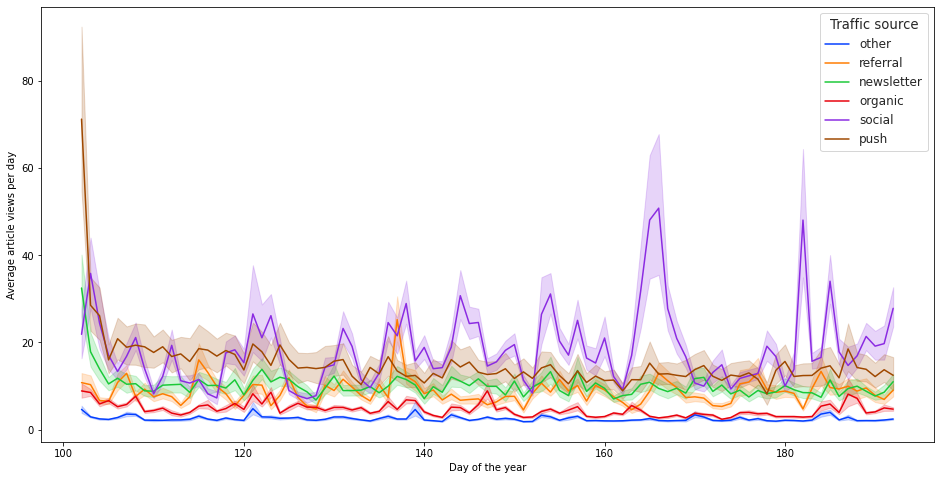

In [46]:
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.lineplot(x="Day", y="Views", hue="Traffic source", data=df3, ax=ax)

ax.set_xlabel("Day of the year")
ax.set_ylabel("Average article views per day")

plt.savefig("Day of the year x Average article views.pdf", format="pdf", bbox_inches="tight")

df3["First timestamp date"] = df3.groupby(["Newspaper", "Landing page"])["Timestamp"].transform("first")

df4 = df3[df3["Publication date"] >= df3["First timestamp date"]].reset_index(drop=True)

df4.head()

df4.drop(columns = ["First timestamp date"], inplace=True)

print(df4.duplicated().value_counts())

df4.drop_duplicates(inplace=True)

df4.head()

df4["Timestamp"] = pd.to_datetime(df4.Timestamp, format="%Y-%m-%d %H:%M:%S")

df4.head()

df5_p = df5_p.groupby(["Newspaper", "Landing page"]).apply(lambda x : x.set_index("Timestamp").resample("1H").sum()).reset_index()

for source in ["newsletter", "organic", "other", "push", "referral", "social"]:
    df5_p[f"Total {source} views"] = df5_p.groupby(["Newspaper", "Landing_page"])[f"{source}"].transform("sum")

df5_p.head()

df5_a = df4.groupby(["Newspaper", "Landing page", "Traffic source"]).apply(lambda x : x
                                                                    .drop_duplicates("Timestamp")
                                                                    .set_index("Timestamp")
                                                                    .resample("1H")
                                                                    .sum()).reset_index()

df5_a.columns = [c.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "").replace(".", "") for c in df5_a.columns]

df5_a["Hour"] = 1
df5_a["Hours_passed"] = df5_a.groupby(["Newspaper", "Landing_page", "Traffic_source"])["Hour"].cumsum()

df5_a.drop(columns = ["Hour"], inplace = True)

## Traffic Source Interactions

In [48]:
#We import some extra libraries for the models that we will run.
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools

In [49]:
#We create a non-lagged dataset for the statistical models.
df3_p_1 = df3_p.groupby(["Newspaper", "Landing_page"]).nth(0).reset_index()

In [50]:
#We will melt the dataset (so make it long again) as this will make the standardization procedure more easy.
total_z_scores = df3_p_1.melt(id_vars=["Newspaper", "Landing_page"],
                              value_vars=["Total_newsletter", 
                                          "Total_organic",
                                          "Total_other", 
                                          "Total_push", 
                                          "Total_referral", 
                                          "Total_social",
                                          "Total_views"])

In [51]:
#We inspect the data.
total_z_scores.head()

,Newspaper,Landing_page,variable,value
0,Gooieneemlander,/cnt/dmf20190705_81476516,Total_newsletter,0
1,Gooieneemlander,/cnt/dmf20200501_53506347,Total_newsletter,1
2,Gooieneemlander,/cnt/dmf20201026_62507126,Total_newsletter,0
3,Gooieneemlander,/cnt/dmf20201113_84348583,Total_newsletter,0
4,Gooieneemlander,/cnt/dmf20201228_15837729,Total_newsletter,0


In [52]:
#We add a column in which we standardize the total views for every traffic source of every newspaper.
total_z_scores["Z_Total_Views"] = total_z_scores.groupby(["Newspaper", "variable"])["value"].transform(lambda x: stats.zscore(x))

In [53]:
#We inspect the column.
total_z_scores.Z_Total_Views.describe()

count    3.258500e+05
mean    -1.138451e-16
std      1.000002e+00
min     -3.470458e-01
25%     -2.097443e-01
50%     -1.514412e-01
75%     -1.001653e-01
max      9.390850e+01
Name: Z_Total_Views, dtype: float64

In [54]:
#We put it back in its wide format as before.
total_z_scores = total_z_scores.pivot_table(columns="variable", 
                                            index = ["Newspaper", "Landing_page"],
                                            values="Z_Total_Views", fill_value=0).reset_index().rename_axis(None, axis=1)

In [55]:
#We inspect the data.
total_z_scores.head()

,Newspaper,Landing_page,Total_newsletter,Total_organic,Total_other,Total_push,Total_referral,Total_social,Total_views
0,Gooieneemlander,/cnt/dmf20190705_81476516,-0.256425,-0.151025,-0.211864,-0.288219,-0.062082,-0.110456,-0.161289
1,Gooieneemlander,/cnt/dmf20200501_53506347,-0.246437,-0.151025,-0.211864,-0.288219,-0.051875,-0.110456,-0.153762
2,Gooieneemlander,/cnt/dmf20201026_62507126,-0.256425,-0.146200,-0.211864,-0.288219,-0.064351,-0.110456,-0.162042
3,Gooieneemlander,/cnt/dmf20201113_84348583,-0.256425,-0.151025,-0.190657,-0.288219,-0.064351,-0.101459,-0.157526
4,Gooieneemlander,/cnt/dmf20201228_15837729,-0.256425,-0.151025,-0.211864,-0.288219,-0.064351,-0.110456,-0.162794


In [56]:
#We create a list of all traffic sources.
sources = ["Total_newsletter", "Total_organic", "Total_other", "Total_push", "Total_referral", "Total_social"]

In [57]:
#We create a formula with total views being the dependent variable.
#As predictors we add all the traffic sources total views, and in addition al combinations of two.
formula = "Total_views ~ " + re.sub("[^A-Za-z0-9*+_ ]+", "", str(list(itertools.combinations(sources, 2))).replace("),", " +").replace(", ", "*"))

In [58]:
#We inspect the formula.
print(formula)

Total_views ~ Total_newsletter*Total_organic + Total_newsletter*Total_other + Total_newsletter*Total_push + Total_newsletter*Total_referral + Total_newsletter*Total_social + Total_organic*Total_other + Total_organic*Total_push + Total_organic*Total_referral + Total_organic*Total_social + Total_other*Total_push + Total_other*Total_referral + Total_other*Total_social + Total_push*Total_referral + Total_push*Total_social + Total_referral*Total_social


## Heatmap Zscore(Total Source Views)

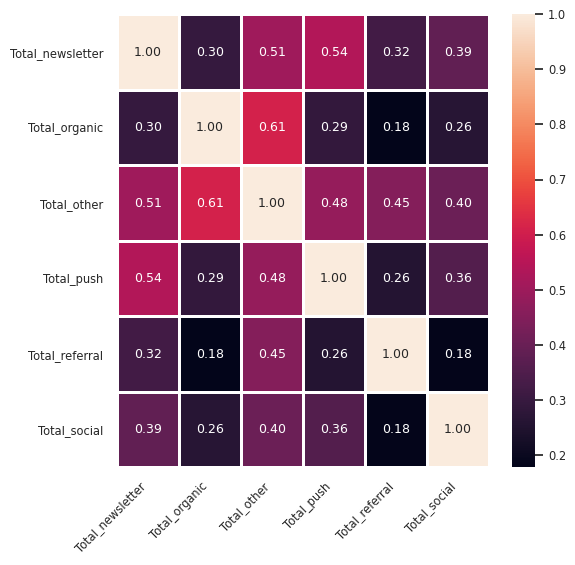

In [59]:
#We first run a correlation plot.
fig = plt.figure(figsize=(6,6), dpi = 100)
sns.set(font_scale=.75)
sns.heatmap(total_z_scores[sources].corr(), annot = True, fmt = '.2f', linewidth=1, linecolor='w')
plt.xticks(rotation=45, ha='right') 
plt.savefig("z-score Total source views correlations.pdf", format="pdf", bbox_inches="tight")

## OLS Total views ~ zscore(Total source views)*zscore(Total source views)

In [60]:
#We run an OLS with our earlier defined formula.
md = smf.ols(formula, total_z_scores)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_views   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 3.507e+04
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        15:05:18   Log-Likelihood:                -343.95
No. Observations:               46550   AIC:                             731.9
Df Residuals:                   46528   BIC:                             924.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [61]:
summary = mdf.summary()
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                    &   Total\_views   & \textbf{  R-squared:         } &       0.941    \\
\textbf{Model:}                            &       OLS        & \textbf{  Adj. R-squared:    } &       0.941    \\
\textbf{Method:}                           &  Least Squares   & \textbf{  F-statistic:       } &   3.507e+04    \\
\textbf{Date:}                             & Wed, 01 May 2024 & \textbf{  Prob (F-statistic):} &       0.00     \\
\textbf{Time:}                             &     15:05:18     & \textbf{  Log-Likelihood:    } &     -343.95    \\
\textbf{No. Observations:}                 &       46550      & \textbf{  AIC:               } &       731.9    \\
\textbf{Df Residuals:}                     &       46528      & \textbf{  BIC:               } &       924.4    \\
\textbf{Df Model:}                         &          21      & \textbf{                     } &                \\
\bottomrule
\end{tabular}
\begin{t

## RQ3: Trajectory & Traffic source

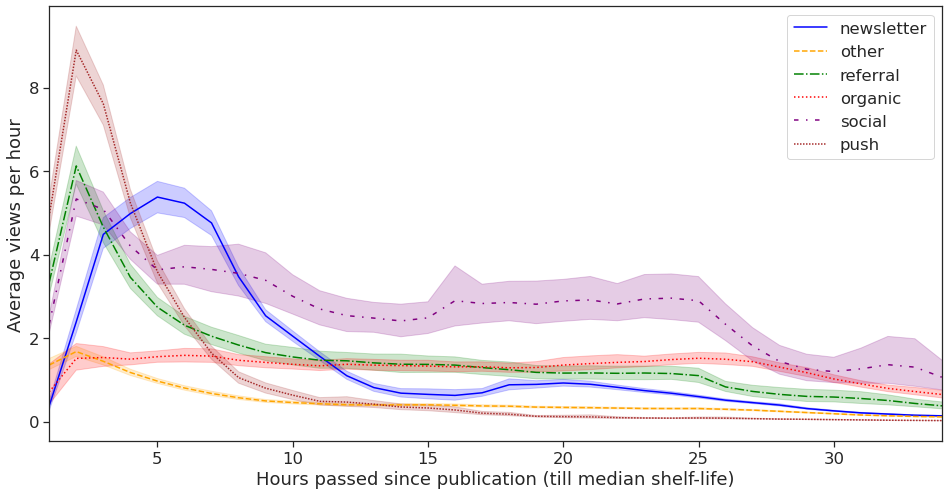

In [68]:
#We plot the trajectory of each traffic source over each other.
#We do so till the median shelf-life (34 hours).
fig, ax = plt.subplots(figsize=(16, 8))

sns.set(style="ticks", font_scale=1.5, palette="bright")

linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (1, 1))]

for source, color, linestyle in zip(["newsletter", "other", "referral", "organic", "social", "push"], 
                                    ["blue", "orange", "green", "red", "purple", "brown"],
                                    linestyles):
    sns.lineplot(x="Hours_passed", y=source, data=df3_p, ax=ax, label=source, color=color, linestyle=linestyle)

ax.set_xlabel("Hours passed since publication (till median shelf-life)")
ax.set_ylabel("Average views per hour")

ax.set_xticks(np.arange(0, 34, 5))
ax.set_xlim(1, 34)

plt.savefig("Hours passed x Number of views x Traffic source (p).pdf", format="pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.lineplot(x="Hours_passed", y="Views", hue="Traffic_source", data=df5_a, ax=ax)

ax.set_xlabel("Hours passed since first appearance in source")
ax.set_ylabel("Average views per hour")

ax.set_xticks(np.arange(0,73,5))

ax.set_xlim(1,73)

plt.savefig("Hours passed x Number of views x Traffic source (a) (V1).pdf", format="pdf", bbox_inches="tight")

push = df5_a[df5_a["Traffic_source"] == "push"]
other = df5_a[df5_a["Traffic_source"] != "push"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.lineplot(x="Hours_passed", y="Views", data=push, color = "brown", ax=ax[0])
sns.lineplot(x="Hours_passed", y="Views", data=other, hue="Traffic_source", ax=ax[1])
    
ax[0].set_title("Push")
ax[0].set_xlim(1,73)
ax[0].set_xlabel("Hours passed since first appearance in source")
ax[0].set_ylabel("Average views per hour")

ax[1].set_title("Other")
ax[1].set_xlim(1,73)
ax[1].set_xlabel("Hours passed since first appearance in source")
ax[1].set_ylabel("Average views per hour")

plt.savefig("Hours passed x Number of views x Traffic source (a) (V2).pdf", format="pdf", bbox_inches="tight")